In [1]:
# imports iniciales
import pandas as pd
import numpy as np
import datetime
from datetime import datetime, timedelta
import utils
import calendar
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [71]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import numpy as np
import datetime
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

In [72]:
## hay 38829 personas en total
events = pd.read_csv('events_up_to_01062018.csv',low_memory=False)
events['person'].drop_duplicates().to_frame().shape

(38829, 1)

In [73]:
## tomo todos los eventos
events = utils.get_events()
events.sort_values(by=['person', 'timestamp'], ascending=[True, True], inplace=True)
events.head()

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,city,region,country,device_type,screen_resolution,operating_system_version,browser_version,month,day,hora
1507286,2018-05-17 12:27:47,checkout,0008ed71,NaN,3372.0,Samsung Galaxy S6 Flat,Muito Bom,32GB,Dourado,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,17,12
2336760,2018-05-17 13:44:59,visited site,0008ed71,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,Unknown,Unknown,Brazil,Computer,1920x1080,Windows 10,Chrome 66.0,5,17,13
1507716,2018-05-17 13:45:00,checkout,0008ed71,NaN,8247.0,iPhone SE,Bom,64GB,Cinza espacial,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,17,13
2336761,2018-05-17 16:21:54,visited site,0008ed71,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,Unknown,Unknown,Brazil,Computer,1920x1080,Windows 10,Chrome 66.0,5,17,16
2122051,2018-05-17 16:22:06,generic listing,0008ed71,NaN,0.0,NaN,NaN,NaN,NaN,"6594,6651,6664,7253,2820,6706,6721,12606,480,1...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,17,16


In [74]:
## ctd de eventos de cada tipo por usuario (todos los usuarios están incluídos -> si o si tienen un evento)
features = utils.get_features_iniciales(events,'event')
print(features.shape)
features.head()

(38829, 12)


event,person,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,visited site
0,0008ed71,0,0,3,0,1,0,0,0,0,0,2
1,00091926,15,25,2,0,0,0,0,0,0,372,34
2,00091a7a,1,5,0,0,0,0,0,0,0,3,1
3,000ba417,1,24,6,1,14,0,1,0,0,153,6
4,000c79fe,1,0,1,0,1,0,1,9,0,3,1


In [75]:
# agrego columnas para segmentar el tiempo 
events.timestamp = pd.to_datetime(events['timestamp'],format='%Y-%m-%d %H:%M:%S')
events['month'] = events.timestamp.dt.month
events['day'] = events.timestamp.dt.day
events['hour'] = events.timestamp.dt.hour
events['weekday name'] = events.timestamp.dt.weekday_name
events[['person','timestamp','month','day','hour','weekday name']].head()

,person,timestamp,month,day,hour,weekday name
1507286,0008ed71,2018-05-17 12:27:47,5,17,12,Thursday
2336760,0008ed71,2018-05-17 13:44:59,5,17,13,Thursday
1507716,0008ed71,2018-05-17 13:45:00,5,17,13,Thursday
2336761,0008ed71,2018-05-17 16:21:54,5,17,16,Thursday
2122051,0008ed71,2018-05-17 16:22:06,5,17,16,Thursday


In [76]:
## 1 si es fin de semana 0 si es dia de semana
events['weekend'] = (events['weekday name'] == 'Saturday') | (events['weekday name'] == 'Sunday')
events['weekend'] = events['weekend'].astype(int)

In [77]:
## paso el mes a nombre
events['month'] = events['month'].apply(lambda x: calendar.month_abbr[x])

In [78]:
def periodioDia(hora):
    if (hora >= 0) & (hora < 7):
        return 'madrugada'
    elif (hora >= 7) & (hora < 12):
        return 'manana'
    elif (hora >= 12) & (hora < 15):
        return 'mediodia'
    elif (hora >= 15) & (hora < 20):
        return 'tarde'
    return 'noche'

events['periodo'] = events['hour'].apply(lambda x: periodioDia(x))

In [79]:
events.head()

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,screen_resolution,operating_system_version,browser_version,month,day,hora,hour,weekday name,weekend,periodo
1507286,2018-05-17 12:27:47,checkout,0008ed71,NaN,3372.0,Samsung Galaxy S6 Flat,Muito Bom,32GB,Dourado,NaN,...,NaN,NaN,NaN,May,17,12,12,Thursday,0,mediodia
2336760,2018-05-17 13:44:59,visited site,0008ed71,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,1920x1080,Windows 10,Chrome 66.0,May,17,13,13,Thursday,0,mediodia
1507716,2018-05-17 13:45:00,checkout,0008ed71,NaN,8247.0,iPhone SE,Bom,64GB,Cinza espacial,NaN,...,NaN,NaN,NaN,May,17,13,13,Thursday,0,mediodia
2336761,2018-05-17 16:21:54,visited site,0008ed71,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,1920x1080,Windows 10,Chrome 66.0,May,17,16,16,Thursday,0,tarde
2122051,2018-05-17 16:22:06,generic listing,0008ed71,NaN,0.0,NaN,NaN,NaN,NaN,"6594,6651,6664,7253,2820,6706,6721,12606,480,1...",...,NaN,NaN,NaN,May,17,16,16,Thursday,0,tarde


In [80]:
#one hot encoding
events = pd.concat([events, pd.get_dummies(events['weekday name'], prefix='weekday')],axis=1)
events = events.drop('weekday name', axis=1)
events = pd.concat([events, pd.get_dummies(events['periodo'], prefix='periodo')],axis=1)
events = events.drop('periodo', axis=1)
events = pd.concat([events, pd.get_dummies(events['month'], prefix='mes')],axis=1)
events = events.drop('month', axis=1)

events = pd.concat([events, pd.get_dummies(events['storage'], prefix='storage')],axis=1)
events = events.drop('storage', axis=1)
events = pd.concat([events, pd.get_dummies(events['condition'], prefix='condition')],axis=1)
events = events.drop('condition', axis=1)

events.head()

,timestamp,event,person,url,sku,model,color,skus,search_term,staticpage,...,storage_32GB,storage_4GB,storage_512MB,storage_64GB,storage_8GB,condition_Bom,condition_Bom - Sem Touch ID,condition_Excelente,condition_Muito Bom,condition_Novo
1507286,2018-05-17 12:27:47,checkout,0008ed71,NaN,3372.0,Samsung Galaxy S6 Flat,Dourado,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,1,0
2336760,2018-05-17 13:44:59,visited site,0008ed71,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1507716,2018-05-17 13:45:00,checkout,0008ed71,NaN,8247.0,iPhone SE,Cinza espacial,NaN,NaN,NaN,...,0,0,0,1,0,1,0,0,0,0
2336761,2018-05-17 16:21:54,visited site,0008ed71,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2122051,2018-05-17 16:22:06,generic listing,0008ed71,NaN,0.0,NaN,NaN,"6594,6651,6664,7253,2820,6706,6721,12606,480,1...",NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [81]:
events.columns

Index(['timestamp', 'event', 'person', 'url', 'sku', 'model', 'color', 'skus',
       'search_term', 'staticpage', 'campaign_source', 'search_engine',
       'channel', 'new_vs_returning', 'city', 'region', 'country',
       'device_type', 'screen_resolution', 'operating_system_version',
       'browser_version', 'day', 'hora', 'hour', 'weekend', 'weekday_Friday',
       'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday',
       'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday',
       'periodo_madrugada', 'periodo_manana', 'periodo_mediodia',
       'periodo_noche', 'periodo_tarde', 'mes_Apr', 'mes_Feb', 'mes_Jan',
       'mes_Mar', 'mes_May', 'storage_128GB', 'storage_16GB', 'storage_256GB',
       'storage_32GB', 'storage_4GB', 'storage_512MB', 'storage_64GB',
       'storage_8GB', 'condition_Bom', 'condition_Bom - Sem Touch ID',
       'condition_Excelente', 'condition_Muito Bom', 'condition_Novo'],
      dtype='object')

In [82]:
events = events[['person', 'day', 'hora', 'hour', 'weekend', 'weekday_Friday',
       'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday',
       'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday',
       'periodo_madrugada', 'periodo_manana', 'periodo_mediodia',
       'periodo_noche', 'periodo_tarde', 'mes_Apr', 'mes_Feb', 'mes_Jan',
       'mes_Mar', 'mes_May', 'storage_128GB', 'storage_16GB', 'storage_256GB',
       'storage_32GB', 'storage_4GB', 'storage_512MB', 'storage_64GB',
       'storage_8GB', 'condition_Bom', 'condition_Bom - Sem Touch ID',
       'condition_Excelente', 'condition_Muito Bom', 'condition_Novo']]
events.dtypes

person                          object
day                              int64
hora                             int64
hour                             int64
weekend                          int64
weekday_Friday                   uint8
weekday_Monday                   uint8
weekday_Saturday                 uint8
weekday_Sunday                   uint8
weekday_Thursday                 uint8
weekday_Tuesday                  uint8
weekday_Wednesday                uint8
periodo_madrugada                uint8
periodo_manana                   uint8
periodo_mediodia                 uint8
periodo_noche                    uint8
periodo_tarde                    uint8
mes_Apr                          uint8
mes_Feb                          uint8
mes_Jan                          uint8
mes_Mar                          uint8
mes_May                          uint8
storage_128GB                    uint8
storage_16GB                     uint8
storage_256GB                    uint8
storage_32GB             

In [83]:
features = pd.merge(features, events.groupby('person').sum().reset_index(), on='person', how='inner')

In [84]:
features.head()

,person,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,...,storage_32GB,storage_4GB,storage_512MB,storage_64GB,storage_8GB,condition_Bom,condition_Bom - Sem Touch ID,condition_Excelente,condition_Muito Bom,condition_Novo
0,0008ed71,0,0,3,0,1,0,0,0,0,...,2.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0
1,00091926,15,25,2,0,0,0,0,0,0,...,132.0,0.0,0.0,80.0,0.0,102.0,0.0,108.0,163.0,1.0
2,00091a7a,1,5,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0
3,000ba417,1,24,6,1,14,0,1,0,0,...,20.0,1.0,0.0,1.0,22.0,115.0,0.0,11.0,34.0,0.0
4,000c79fe,1,0,1,0,1,0,1,9,0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0


In [85]:
features.columns

Index(['person', 'ad campaign hit', 'brand listing', 'checkout', 'conversion',
       'generic listing', 'lead', 'search engine hit', 'searched products',
       'staticpage', 'viewed product', 'visited site', 'day', 'hora', 'hour',
       'weekend', 'weekday_Friday', 'weekday_Monday', 'weekday_Saturday',
       'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday',
       'weekday_Wednesday', 'periodo_madrugada', 'periodo_manana',
       'periodo_mediodia', 'periodo_noche', 'periodo_tarde', 'mes_Apr',
       'mes_Feb', 'mes_Jan', 'mes_Mar', 'mes_May', 'storage_128GB',
       'storage_16GB', 'storage_256GB', 'storage_32GB', 'storage_4GB',
       'storage_512MB', 'storage_64GB', 'storage_8GB', 'condition_Bom',
       'condition_Bom - Sem Touch ID', 'condition_Excelente',
       'condition_Muito Bom', 'condition_Novo'],
      dtype='object')

In [86]:
events = pd.read_csv('events_up_to_01062018.csv',low_memory=False)
events.timestamp = pd.to_datetime(events['timestamp'],format='%Y-%m-%d %H:%M:%S')

# Tomo como sesión media hora
events = events.sort_values(by='timestamp')
events['timestamp_anterior'] = events.groupby('person')['timestamp'].shift()
events['start_session'] = ((events['timestamp'] - events['timestamp_anterior']) >= timedelta(minutes=30)) | events['timestamp_anterior'].isnull()
events['start_session'] = events['start_session'].astype(int)
events['session_num'] = events.groupby('person')['start_session'].cumsum()
events['session_id'] =  events['person'] + '-' + events['session_num'].astype(str)

In [87]:
session_df = events.groupby(['session_id','person']).agg({'event':'count', 'timestamp':['min','max']})
session_df.columns = session_df.columns.droplevel()
session_df.columns = ['number_events','timestamp_min','timestamp_max']
session_df['total_time'] = ((session_df['timestamp_max']) - session_df['timestamp_min']).astype('timedelta64[s]')
session_df = session_df.reset_index().sort_values(by='session_id')
session_df.head()

,session_id,person,number_events,timestamp_min,timestamp_max,total_time
0,0008ed71-1,0008ed71,1,2018-05-17 12:27:47,2018-05-17 12:27:47,0.0
1,0008ed71-2,0008ed71,2,2018-05-17 13:44:59,2018-05-17 13:45:00,1.0
2,0008ed71-3,0008ed71,3,2018-05-17 16:21:54,2018-05-17 16:28:37,403.0
3,00091926-1,00091926,7,2018-05-03 22:08:29,2018-05-03 22:09:59,90.0
4,00091926-10,00091926,4,2018-05-11 02:23:38,2018-05-11 02:23:57,19.0


In [88]:
sessions_by_person = session_df.groupby(['person']).agg({'session_id':'count', 'total_time':['sum','mean','max'], 'number_events':['mean', 'max'], 'timestamp_max':'max'})
sessions_by_person.columns = sessions_by_person.columns.droplevel()
sessions_by_person.columns = ['sessions', 'total_time', 'mean_time_by_session', 'max_session_time', 'mean_events_by_session', 'max_events_by_session', 'days_since_last_session']
sessions_by_person = sessions_by_person.reset_index()
sessions_by_person['days_since_last_session'] = pd.datetime.today() - sessions_by_person['days_since_last_session']
sessions_by_person['days_since_last_session'] = sessions_by_person['days_since_last_session'].dt.days
sessions_by_person.head()

,person,sessions,total_time,mean_time_by_session,max_session_time,mean_events_by_session,max_events_by_session,days_since_last_session
0,0008ed71,3,404.0,134.666667,403.0,2.000000,3,193
1,00091926,34,14890.0,437.941176,2129.0,13.176471,63,179
2,00091a7a,1,347.0,347.000000,347.0,10.000000,10,245
3,000ba417,5,12703.0,2540.600000,5450.0,41.200000,79,184
4,000c79fe,1,620.0,620.000000,620.0,17.000000,17,182


In [89]:
sessions_by_person.shape

(38829, 8)

In [90]:
features = pd.merge(features, sessions_by_person, on='person', how='inner')
features.head()

,person,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,...,condition_Excelente,condition_Muito Bom,condition_Novo,sessions,total_time,mean_time_by_session,max_session_time,mean_events_by_session,max_events_by_session,days_since_last_session
0,0008ed71,0,0,3,0,1,0,0,0,0,...,0.0,1.0,0.0,3,404.0,134.666667,403.0,2.000000,3,193
1,00091926,15,25,2,0,0,0,0,0,0,...,108.0,163.0,1.0,34,14890.0,437.941176,2129.0,13.176471,63,179
2,00091a7a,1,5,0,0,0,0,0,0,0,...,2.0,0.0,0.0,1,347.0,347.000000,347.0,10.000000,10,245
3,000ba417,1,24,6,1,14,0,1,0,0,...,11.0,34.0,0.0,5,12703.0,2540.600000,5450.0,41.200000,79,184
4,000c79fe,1,0,1,0,1,0,1,9,0,...,0.0,0.0,0.0,1,620.0,620.000000,620.0,17.000000,17,182


In [91]:
# Se guardan los features finales en un csv en la carpeta modelos, para que lo levante el modlo a entrenar
features.to_csv('../modelos/data_set.csv',index=False)

In [92]:
# no perdí ningun usuario
features.shape

(38829, 53)

In [93]:
#################################################################

In [94]:
########## https://jessesw.com/XG-Boost/

In [95]:
training_labels = pd.read_csv("labels_training_set.csv", low_memory=False)
labels_predict = pd.read_csv("trocafone_kaggle_test.csv", low_memory=False)
features = pd.read_csv('../modelos/data_set.csv', low_memory = False)

In [96]:
training_labels.shape

(19414, 2)

In [97]:
labels_predict.shape

(19415, 1)

In [98]:
training_labels = pd.merge(features, training_labels, on='person', how='inner')
print(training_labels.shape)
training_labels.head(2)

(19414, 54)


,person,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,...,condition_Muito Bom,condition_Novo,sessions,total_time,mean_time_by_session,max_session_time,mean_events_by_session,max_events_by_session,days_since_last_session,label
0,0008ed71,0,0,3,0,1,0,0,0,0,...,1.0,0.0,3,404.0,134.666667,403.0,2.0,3,193,0
1,000c79fe,1,0,1,0,1,0,1,9,0,...,0.0,0.0,1,620.0,620.000000,620.0,17.0,17,182,0


In [99]:
labels_predict = pd.merge(features, labels_predict, on='person', how='inner')
print(labels_predict.shape)
labels_predict.head(2)

(19415, 53)


,person,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,...,condition_Excelente,condition_Muito Bom,condition_Novo,sessions,total_time,mean_time_by_session,max_session_time,mean_events_by_session,max_events_by_session,days_since_last_session
0,00091926,15,25,2,0,0,0,0,0,0,...,108.0,163.0,1.0,34,14890.0,437.941176,2129.0,13.176471,63,179
1,00091a7a,1,5,0,0,0,0,0,0,0,...,2.0,0.0,0.0,1,347.0,347.000000,347.0,10.000000,10,245


In [100]:
train = training_labels
target = 'label'
IDcol = 'person'

In [101]:
predictors = [x for x in train.columns if x not in [target, IDcol]]

In [102]:
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1) 

In [103]:
optimized_GBM.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [104]:
optimized_GBM.grid_scores_

[mean: 0.94571, std: 0.00072, params: {'max_depth': 3, 'min_child_weight': 1},
 mean: 0.94602, std: 0.00114, params: {'max_depth': 3, 'min_child_weight': 3},
 mean: 0.94633, std: 0.00160, params: {'max_depth': 3, 'min_child_weight': 5},
 mean: 0.94602, std: 0.00133, params: {'max_depth': 5, 'min_child_weight': 1},
 mean: 0.94633, std: 0.00167, params: {'max_depth': 5, 'min_child_weight': 3},
 mean: 0.94525, std: 0.00165, params: {'max_depth': 5, 'min_child_weight': 5},
 mean: 0.94700, std: 0.00072, params: {'max_depth': 7, 'min_child_weight': 1},
 mean: 0.94581, std: 0.00149, params: {'max_depth': 7, 'min_child_weight': 3},
 mean: 0.94468, std: 0.00163, params: {'max_depth': 7, 'min_child_weight': 5}]

In [105]:
####### mejor [mean: 0.94622, std: 0.00076, params: {'max_depth': 3, 'min_child_weight': 1},


In [106]:
xgdmat = xgb.DMatrix(train[predictors],train[target])

In [107]:
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 
              'max_depth':3, 'min_child_weight':1} 

cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat, num_boost_round = 3000, nfold = 5,
                metrics = ['error'],
                early_stopping_rounds = 100)

[13:12:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:36] /work

[13:12:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:37] /work

[13:12:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:38] /work

[13:12:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:39] /work

[13:12:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[13:12:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:40] /work

[13:12:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[13:12:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[13:12:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[13:12:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[13:12:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:42] /works

[13:12:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[13:12:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[13:12:43] /work

[13:12:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[13:12:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[13:12:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[13:12:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:44] /work

[13:12:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[13:12:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[13:12:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:45] /work

[13:12:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[13:12:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[13:12:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[13:12:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[13:12:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:12:47] /works

In [108]:
cv_xgb.tail(5)

,train-error-mean,train-error-std,test-error-mean,test-error-std
33,0.049474,0.000621,0.050222,0.002255
34,0.049410,0.000633,0.050222,0.002255
35,0.049307,0.000661,0.050325,0.002138
36,0.049204,0.000698,0.050273,0.002280
37,0.049140,0.000706,0.050015,0.002143


In [109]:
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 
              'max_depth':3, 'min_child_weight':1} 
## round 54 ( de arriba )
final_gb = xgb.train(our_params, xgdmat, num_boost_round = 37)

[13:13:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:13:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:13:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:13:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:13:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[13:13:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:13:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:13:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13:13:23] /work

In [110]:
##########

In [111]:
%matplotlib inline
import seaborn as sns
sns.set(font_scale = 1.5)

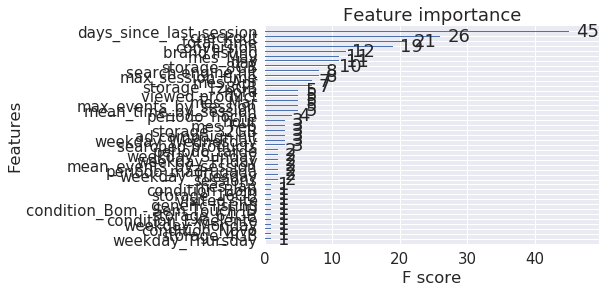

In [112]:
xgb.plot_importance(final_gb) # fixear

In [113]:
importances = final_gb.get_fscore()
importances

{'checkout': 26,
 'max_session_time': 8,
 'storage_8GB': 10,
 'sessions': 2,
 'days_since_last_session': 45,
 'day': 11,
 'total_time': 21,
 'mean_time_by_session': 5,
 'storage_128GB': 7,
 'conversion': 19,
 'max_events_by_session': 5,
 'searched products': 3,
 'mes_Apr': 7,
 'weekday_Thursday': 1,
 'mes_Mar': 5,
 'brand listing': 12,
 'weekday_Wednesday': 3,
 'ad campaign hit': 3,
 'weekday_Tuesday': 2,
 'periodo_madrugada': 2,
 'mes_May': 11,
 'storage_4GB': 1,
 'viewed product': 5,
 'search engine hit': 8,
 'condition_Novo': 1,
 'mean_events_by_session': 2,
 'storage_32GB': 3,
 'mes_Feb': 3,
 'weekday_Monday': 1,
 'hour': 3,
 'hora': 5,
 'periodo_noche': 4,
 'weekday_Friday': 2,
 'condition_Excelente': 1,
 'weekday_Sunday': 2,
 'storage_64GB': 1,
 'periodo_tarde': 2,
 'condition_Bom - Sem Touch ID': 1,
 'generic listing': 1,
 'visited site': 1,
 'storage_16GB': 1,
 'condition_Bom': 1,
 'mes_Jan': 1}

In [ ]:
################### FALTA SEPARAR EN TEST Y TRAIN PARA HACER ESTO

In [ ]:
#testdmat = xgb.DMatrix(x_test)

In [ ]:
#from sklearn.metrics import accuracy_score
#y_pred = final_gb.predict(testdmat) # Predict using our testdmat
#y_pred

In [ ]:
#y_pred[y_pred > 0.5] = 1
#y_pred[y_pred <= 0.5] = 0
#y_pred

In [ ]:
#accuracy_score(y_pred, y_test), 1-accuracy_score(y_pred, y_test)


In [ ]:
################ pred finales p kaggle

In [114]:
set_test = labels_predict
personas = set_test["person"]
set_test = set_test.drop(columns=['person'])
set_test = set_test.fillna(0)

final_test = set_test
testdmat = xgb.DMatrix(final_test)

In [115]:
y_pred = final_gb.predict(testdmat) # Predict using our testdmat
y_pred

array([0.0660878 , 0.16679132, 0.06858692, ..., 0.12076966, 0.06431318,
       0.02368867], dtype=float32)

In [116]:
predicts_kaggel = y_pred.tolist()


In [65]:
#convert into binary values
#for i in range(0,len(predicts_kaggel)):
#    if predicts_kaggel[i]>=.5:       # setting threshold to .5
#       predicts_kaggel[i]=1
#    else:  
#       predicts_kaggel[i]=0

In [117]:
df_kaggel = pd.DataFrame(predicts_kaggel)
df_kaggel.head()

,0
0,0.066088
1,0.166791
2,0.068587
3,0.069004
4,0.032391


In [118]:
df_kaggel["person"] = personas
df_kaggel.rename(columns = {0: 'label'},inplace = True) 

In [119]:
df_kaggel = df_kaggel[['person','label']]

In [120]:
df_kaggel.to_csv('Resultados_new_xgb.csv',index=False)

In [121]:
df_kaggel['label'].value_counts()

0.019982    1891
0.022387    1441
0.023689     733
0.020997     274
0.021089     245
0.021147     225
0.023228     195
0.023496     168
0.022723     154
0.024356     149
0.062473     146
0.024860     126
0.024440     126
0.026731     120
0.020974     111
0.030395     110
0.028736     102
0.024044      64
0.026672      63
0.023865      56
0.031887      55
0.078118      50
0.069004      49
0.027154      48
0.025439      48
0.029559      46
0.025250      46
0.025433      42
0.024038      41
0.071742      41
            ... 
0.053961       1
0.129908       1
0.184597       1
0.034431       1
0.107924       1
0.200203       1
0.231743       1
0.155399       1
0.100093       1
0.072742       1
0.145485       1
0.200179       1
0.215804       1
0.072746       1
0.061764       1
0.168931       1
0.030882       1
0.096186       1
0.046421       1
0.030033       1
0.036375       1
0.115719       1
0.176752       1
0.192379       1
0.184569       1
0.055908       1
0.323049       1
0.029908      